Installing (updating) the following libraries for your Sagemaker
instance.

In [ ]:
!pip install .. # installing d2l


# Caixas de Âncora
:label:`sec_anchor`

Os algoritmos de detecção de objetos geralmente amostram um grande número de regiões na imagem de entrada, determinam se essas regiões contêm objetos de interesse e ajustam as bordas das regiões de modo a prever a caixa delimitadora da verdade terrestre do alvo com mais precisão. Diferentes modelos podem usar diferentes métodos de amostragem de região. Aqui, apresentamos um desses métodos: ele gera várias caixas delimitadoras com diferentes tamanhos e proporções de aspecto, enquanto é centralizado em cada pixel. Essas caixas delimitadoras são chamadas de caixas de âncora. Praticaremos a detecção de objetos com base em caixas de âncora nas seções a seguir.


Primeiro, importe os pacotes ou módulos necessários para esta seção. Aqui, modificamos a precisão de impressão do PyTorch. Como os tensores de impressão, na verdade, chamam a função de impressão de PyTorch, os números de ponto flutuante nos tensores impressos nesta seção são mais concisos.


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

torch.set_printoptions(2)

## Gerando Várias Caixas de Âncora


Suponha que a imagem de entrada tenha uma altura de $h$ e uma largura de $w$. Geramos caixas de âncora com diferentes formas centralizadas em cada pixel da imagem. Suponha que o tamanho seja $s\in (0, 1]$, a proporção da imagem é $r > 0$ e a largura e a altura da caixa de âncora são $ws\sqrt{r}$ e $hs/\sqrt{r}$, respectivamente. Quando a posição central é fornecida, uma caixa de âncora com largura e altura conhecidas é determinada.

Abaixo, definimos um conjunto de tamanhos $s_1,\ldots, s_n$ e um conjunto de relações de aspecto $r_1,\ldots, r_m$. Se usarmos uma combinação de todos os tamanhos e proporções com cada pixel como o centro, a imagem de entrada terá um total de $whnm$ caixas de âncora. Embora essas caixas de âncora possam abranger todas as caixas delimitadoras da verdade, a complexidade computacional costuma ser excessiva. Portanto, normalmente estamos interessados apenas em uma combinação contendo $s_1$ ou $r_1$ tamanhos e proporções, isto é:

$$(s_1, r_1), (s_1, r_2), \ldots, (s_1, r_m), (s_2, r_1), (s_3, r_1), \ldots, (s_n, r_1).$$


Ou seja, o número de caixas de âncora centradas no mesmo pixel é $n+m-1$. Para toda a imagem de entrada, geraremos um total de $wh(n+m-1)$ caixas de âncora.

O método acima para gerar caixas de âncora foi implementado na função `multibox_prior`. Especificamos a entrada, um conjunto de tamanhos e um conjunto de proporções, e esta função retornará todas as caixas de âncora inseridas.


In [2]:
#@save
def multibox_prior(data, sizes, ratios):
    in_height, in_width = data.shape[-2:]
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = (num_sizes + num_ratios - 1)
    size_tensor = torch.tensor(sizes, device=device)
    ratio_tensor = torch.tensor(ratios, device=device)
    # Offsets are required to move the anchor to center of a pixel
    # Since pixel (height=1, width=1), we choose to offset our centers by 0.5
    offset_h, offset_w = 0.5, 0.5
    steps_h = 1.0 / in_height  # Scaled steps in y axis
    steps_w = 1.0 / in_width  # Scaled steps in x axis

    # Generate all center points for the anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * steps_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * steps_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w)
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate boxes_per_pixel number of heights and widths which are later
    # used to create anchor box corner coordinates (xmin, xmax, ymin, ymax)
    # cat (various sizes, first ratio) and (first size, various ratios)
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:])))\
                   * in_height / in_width  # handle rectangular inputs
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))
    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(
                                        in_height * in_width, 1) / 2

    # Each center point will have boxes_per_pixel number of anchor boxes, so
    # generate grid of all anchor box centers with boxes_per_pixel repeats
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y],
                dim=1).repeat_interleave(boxes_per_pixel, dim=0)

    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

Podemos ver que a forma da variável de caixa de âncora retornada `y` é
(tamanho do lote, número de caixas de âncora, 4).


In [3]:
img = d2l.plt.imread('../img/catdog.jpg')
h, w = img.shape[0:2]

print(h, w)
X = torch.rand(size=(1, 3, h, w))  # Construct input data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


torch.Size([1, 2042040, 4])

Depois de alterar a forma da variável da caixa de âncora `y` para (altura da imagem, largura da imagem, número de caixas de âncora centradas no mesmo pixel, 4), podemos obter todas as caixas de âncora centradas em uma posição de pixel especificada. No exemplo a seguir, acessamos a primeira caixa de âncora centrada em (250, 250). Ele tem quatro elementos: as coordenadas do eixo $x, y$ no canto superior esquerdo e as coordenadas do eixo $x, y$ no canto inferior direito da caixa de âncora. Os valores das coordenadas dos eixos $x$ e $y$ são divididos pela largura e altura da imagem, respectivamente, portanto, o intervalo de valores está entre 0 e 1.


In [4]:
boxes = Y.reshape(h, w, 5, 4)
boxes[250, 250, 0, :]

tensor([0.06, 0.07, 0.63, 0.82])

Para descrever todas as caixas de âncora centralizadas em um pixel na imagem, primeiro definimos a função `show_bboxes` para desenhar várias caixas delimitadoras na imagem.


In [5]:
#@save
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.detach().numpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

Como acabamos de ver, os valores das coordenadas dos eixos $x$ e $y$ na variável `caixas` foram divididos pela largura e altura da imagem, respectivamente. Ao desenhar imagens, precisamos restaurar os valores das coordenadas originais das caixas de âncora e, portanto, definir a variável `bbox_scale`. Agora, podemos desenhar todas as caixas de âncora centralizadas em (250, 250) na imagem. Como você pode ver, a caixa de âncora azul com um tamanho de 0,75 e uma proporção de 1 cobre bem o cão na imagem.


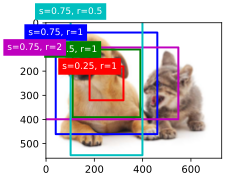

In [6]:
d2l.set_figsize()
bbox_scale = torch.tensor((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## Interseção sobre União

Acabamos de mencionar que a caixa de âncora cobre bem o cachorro na imagem. Se a caixa delimitadora da verdade básica do alvo é conhecida, como o "bem" pode ser quantificado aqui? Um método intuitivo é medir a semelhança entre as caixas de âncora e a caixa delimitadora da verdade absoluta. Sabemos que o índice de Jaccard pode medir a semelhança entre dois conjuntos. Dados os conjuntos $\mathcal{A}$ e $\mathcal{B}$, seu índice de Jaccard é o tamanho de sua interseção dividido pelo tamanho de sua união:

$$J(\mathcal{A},\mathcal{B}) = \frac{\left|\mathcal{A} \cap \mathcal{B}\right|}{\left| \mathcal{A} \cup \mathcal{B}\right|}.$$


Na verdade, podemos considerar a área de pixels de uma caixa delimitadora como uma coleção de pixels. Dessa forma, podemos medir a similaridade das duas caixas delimitadoras pelo índice de Jaccard de seus conjuntos de pixels. Quando medimos a similaridade de duas caixas delimitadoras, geralmente nos referimos ao índice de Jaccard como interseção sobre união (IoU), que é a razão entre a área de interseção e a área de união das duas caixas delimitadoras, conforme mostrado em :numref:`fig_iou`. O intervalo de valores de IoU está entre 0 e 1: 0 significa que não há pixels sobrepostos entre as duas caixas delimitadoras, enquanto 1 indica que as duas caixas delimitadoras são iguais.

![IoU é a razão entre a área de interseção e a área de união de duas caixas delimitadoras.](../img/iou.svg)
:label:`fig_iou`


Para o restante desta seção, usaremos IoU para medir a semelhança entre as caixas de âncora e as caixas delimitadoras de verdade terrestre e entre as diferentes caixas de âncora.


In [7]:
#@save
def box_iou(boxes1, boxes2):
    """Compute IOU between two sets of boxes of shape (N,4) and (M,4)."""
    # Compute box areas
    box_area = lambda boxes: ((boxes[:, 2] - boxes[:, 0]) *
                              (boxes[:, 3] - boxes[:, 1]))
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N,M,2]
    rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N,M,2]
    wh = (rb - lt).clamp(min=0)  # [N,M,2]
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]
    unioun = area1[:, None] + area2 - inter
    return inter / unioun

## Rotulagem de Treinamento para Definir Caixas de Âncora



No conjunto de treinamento, consideramos cada caixa de âncora como um exemplo de treinamento. Para treinar o modelo de detecção de objetos, precisamos marcar dois tipos de rótulos para cada caixa de âncora: primeiro, a categoria do alvo contido na caixa de âncora (categoria) e, em segundo lugar, o deslocamento da caixa delimitadora da verdade básica em relação à caixa de âncora (deslocamento). Na detecção de objetos, primeiro geramos várias caixas de âncora, predizemos as categorias e deslocamentos para cada caixa de âncora, ajustamos a posição da caixa de âncora de acordo com o deslocamento previsto para obter as caixas delimitadoras a serem usadas para previsão e, finalmente, filtramos as caixas delimitadoras de predição que precisam ser produzidos.


Sabemos que, no conjunto de treinamento de detecção de objetos, cada imagem é rotulada com a localização da caixa delimitadora da verdade terrestre e a categoria do alvo contido. Depois que as caixas de âncora são geradas, rotulamos principalmente as caixas de âncora com base na localização e nas informações de categoria das caixas delimitadoras de verdade terrestre semelhantes às caixas de âncora. Então, como atribuímos caixas delimitadoras de verdade terrestre a caixas de ancoragem semelhantes a elas?


Suponha que as caixas de ancoragem na imagem sejam $A_1, A_2, \ldots, A_{n_a}$ e as caixas delimitadoras de verdade são $B_1, B_2, \ldots, B_{n_b}$ e $n_a \geq n_b$. Defina a matriz $\mathbf{X} \in \mathbb{R}^{n_a \times n_b}$, onde o elemento $x_{ij}$ na linha $i^\mathrm{th}$ e coluna $j^\mathrm{th}$ é a IoU da caixa de âncora $A_i$ para a caixa delimitadora da verdade básica $B_j$.
Primeiro, encontramos o maior elemento na matriz $\mathbf{X}$ e registramos o índice da linha e o índice da coluna do elemento como $i_1,j_1$. Atribuímos a caixa delimitadora da verdade básica $B_{j_1}$ à caixa âncora $A_{i_1}$. Obviamente, a caixa de âncora $A_{i_1}$ e a caixa delimitadora da verdade básica $B_{j_1}$ têm a maior similaridade entre todos os pares "caixa de âncora - caixa delimitadora da verdade". A seguir, descarte todos os elementos da $i_1$ª linha e da $j_1$ª coluna da matriz $\mathbf{X}$. Encontre o maior elemento restante na matriz  $\mathbf{X}$ e registre o índice da linha e o índice da coluna do elemento como $i_2,j_2$. Atribuímos a caixa delimitadora de verdade básica $B_{j_2}$ à caixa de ancoragem $A_{i_2}$ e, em seguida, descartamos todos os elementos na $i_2$ª linha e na $j_2$ª coluna na matriz $\mathbf{X}$. Neste ponto, os elementos em duas linhas e duas colunas na matriz $\mathbf{X}$ foram descartados.



Prosseguimos até que todos os elementos da coluna $n_b$ da matriz $\mathbf{X}$ sejam descartados. Neste momento, atribuímos uma caixa delimitadora de verdade terrestre a cada uma das caixas de âncora $n_b$.
Em seguida, percorremos apenas as caixas de âncora $n_a - n_b$ restantes. Dada a caixa de âncora $A_i$, encontre a caixa delimitadora $B_j$ com o maior IoU com $A_i$ de acordo com a $i^\mathrm{th}$ linha da matriz $\mathbf{X}$, e apenas atribua o terreno -caixa delimitadora da verdade $B_j$ para ancorar a caixa $A_i$ quando o IoU é maior do que o limite predeterminado.


Conforme mostrado em :numref:`fig_anchor_label` (esquerda), assumindo que o valor máximo na matriz $\mathbf{X}$ é $x_{23}$, iremos atribuir a caixa delimitadora da verdade básica $B_3$ à caixa de âncora $A_2$.. Em seguida, descartamos todos os elementos na linha 2 e coluna 3 da matriz, encontramos o maior elemento $x_{71}$ da área sombreada restante e atribuímos a caixa delimitadora de verdade básica $B_1$ à caixa de ancoragem $A_7$. Então, como mostrado em :numref:`fig_anchor_label` (meio), descarte todos os elementos na linha 7 e coluna 1 da matriz, encontre o maior elemento $x_{54}$ da área sombreada restante e atribua a caixa delimitadora de verdade fundamental $B_4$ para a caixa âncora $A_5$. Finalmente, como mostrado em :numref:`fig_anchor_label` (direita), descarte todos os elementos na linha 5 e coluna 4 da matriz, encontre o maior elemento $x_{92}$ da área sombreada restante e atribua a caixa delimitadora da verdade fundamental $B_2$ para a caixa âncora $A_9$. Depois disso, só precisamos atravessar as caixas de âncora restantes de $A_1, A_3, A_4, A_6, A_8$ e determinar se devemos atribuir caixas delimitadoras de verdade fundamental às caixas de âncora restantes de acordo com o limite.

![Atribua caixas delimitadoras de base de verdade às caixas de ancoragem.](../img/anchor-label.svg)
:label:`fig_anchor_label`


In [8]:
#@save
def match_anchor_to_bbox(ground_truth, anchors, device, iou_threshold=0.5):
    """Assign ground-truth bounding boxes to anchor boxes similar to them."""
    num_anchors, num_gt_boxes = anchors.shape[0], ground_truth.shape[0]
    # Element `x_ij` in the `i^th` row and `j^th` column is the IoU
    # of the anchor box `anc_i` to the ground-truth bounding box `box_j`
    jaccard = box_iou(anchors, ground_truth)
    # Initialize the tensor to hold assigned ground truth bbox for each anchor
    anchors_bbox_map = torch.full((num_anchors,), -1, dtype=torch.long,
                                  device=device)
    # Assign ground truth bounding box according to the threshold
    max_ious, indices = torch.max(jaccard, dim=1)
    anc_i = torch.nonzero(max_ious >= 0.5).reshape(-1)
    box_j = indices[max_ious >= 0.5]
    anchors_bbox_map[anc_i] = box_j
    # Find the largest iou for each bbox
    col_discard = torch.full((num_anchors,), -1)
    row_discard = torch.full((num_gt_boxes,), -1)
    for _ in range(num_gt_boxes):
        max_idx = torch.argmax(jaccard)
        box_idx = (max_idx % num_gt_boxes).long()
        anc_idx = (max_idx / num_gt_boxes).long()
        anchors_bbox_map[anc_idx] = box_idx
        jaccard[:, box_idx] = col_discard
        jaccard[anc_idx, :] = row_discard
    return anchors_bbox_map

Agora podemos rotular as categorias e deslocamentos das caixas de âncora. Se uma caixa de âncora $A$ for atribuída a uma caixa delimitadora de verdade fundamental $B$, a categoria da caixa de âncora $A$ será definida como a categoria de $B$. E o deslocamento da caixa âncora $A$ é definido de acordo com a posição relativa das coordenadas centrais de $B$ e $A$ e os tamanhos relativos das duas caixas. Como as posições e tamanhos de várias caixas no conjunto de dados podem variar, essas posições e tamanhos relativos geralmente requerem algumas transformações especiais para tornar a distribuição de deslocamento mais uniforme e fácil de ajustar. Suponha que as coordenadas centrais da caixa de âncora $A$ e sua caixa delimitadora de verdade fundamental $ B $ sejam $(x_a, y_a), (x_b, y_b)$, as larguras de $A$ e $B$ são $w_a, w_b$, e suas alturas são $h_a, h_b$, respectivamente. Neste caso, uma técnica comum é rotular o deslocamento de $A$ como

$$\left( \frac{ \frac{x_b - x_a}{w_a} - \mu_x }{\sigma_x},
\frac{ \frac{y_b - y_a}{h_a} - \mu_y }{\sigma_y},
\frac{ \log \frac{w_b}{w_a} - \mu_w }{\sigma_w},
\frac{ \log \frac{h_b}{h_a} - \mu_h }{\sigma_h}\right),$$

Os valores padrão da constante são $\mu_x = \mu_y = \mu_w = \mu_h = 0, \sigma_x=\sigma_y=0.1, \text{ e } \sigma_w=\sigma_h=0.2$.
Esta transformação é implementada abaixo na função `offset_boxes`.
Se uma caixa de âncora não for atribuída a uma caixa delimitadora de verdade, só precisamos definir a categoria da caixa de âncora como segundo plano. As caixas de âncora cuja categoria é o plano de fundo costumam ser chamadas de caixas de âncora negativas e o restante é chamado de caixas de âncora positivas.


In [9]:
#@save
def offset_boxes(anchors, assigned_bb, eps=1e-6):
    c_anc = d2l.box_corner_to_center(anchors)
    c_assigned_bb = d2l.box_corner_to_center(assigned_bb)
    offset_xy = 10 * (c_assigned_bb[:, :2] - c_anc[:, :2]) / c_anc[:, 2:]
    offset_wh = 5 * torch.log(eps + c_assigned_bb[:, 2:] / c_anc[:, 2:])
    offset = torch.cat([offset_xy, offset_wh], axis=1)
    return offset

In [10]:
#@save
def multibox_target(anchors, labels):
    batch_size, anchors = labels.shape[0], anchors.squeeze(0)
    batch_offset, batch_mask, batch_class_labels = [], [], []
    device, num_anchors = anchors.device, anchors.shape[0]
    for i in range(batch_size):
        label = labels[i, :, :]
        anchors_bbox_map = match_anchor_to_bbox(label[:, 1:], anchors, device)
        bbox_mask = ((anchors_bbox_map >= 0).float().unsqueeze(-1)).repeat(1, 4)
        # Initialize class_labels and assigned bbox coordinates with zeros
        class_labels = torch.zeros(num_anchors, dtype=torch.long,
                                   device=device)
        assigned_bb = torch.zeros((num_anchors, 4), dtype=torch.float32,
                                  device=device)
        # Assign class labels to the anchor boxes using matched gt bbox labels
        # If no gt bbox is assigned to an anchor box, then let the
        # class_labels and assigned_bb remain zero, i.e the background class
        indices_true = torch.nonzero(anchors_bbox_map >= 0)
        bb_idx = anchors_bbox_map[indices_true]
        class_labels[indices_true] = label[bb_idx, 0].long() + 1
        assigned_bb[indices_true] = label[bb_idx, 1:]
        # offset transformations
        offset = offset_boxes(anchors, assigned_bb) * bbox_mask
        batch_offset.append(offset.reshape(-1))
        batch_mask.append(bbox_mask.reshape(-1))
        batch_class_labels.append(class_labels)
    bbox_offset = torch.stack(batch_offset)
    bbox_mask = torch.stack(batch_mask)
    class_labels = torch.stack(batch_class_labels)
    return (bbox_offset, bbox_mask, class_labels)

Abaixo, demonstramos um exemplo detalhado. Definimos caixas delimitadoras de verdade para o gato e o cachorro na imagem lida, onde o primeiro elemento é a categoria (0 para cachorro, 1 para gato) e os quatro elementos restantes são as coordenadas do eixo $x, y$ no canto superior esquerdo canto e coordenadas do eixo $x, y$ no canto inferior direito (o intervalo de valores está entre 0 e 1). Aqui, construímos cinco caixas de âncora para serem rotuladas pelas coordenadas do canto superior esquerdo e do canto inferior direito, que são registradas como $A_0, \ldots, A_4$, respectivamente (o índice no programa começa em 0) . Primeiro, desenhe as posições dessas caixas de âncora e das caixas delimitadoras da verdade fundamental na imagem.


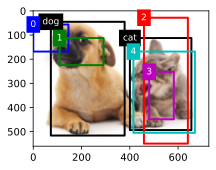

In [11]:
ground_truth = torch.tensor([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = torch.tensor([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

Podemos rotular categorias e deslocamentos para caixas de âncora usando a função `multibox_target`. Esta função define a categoria de fundo para 0 e incrementa o índice inteiro da categoria de destino de zero por 1 (1 para cachorro e 2 para gato).


Adicionamos dimensões de exemplo às caixas de âncora e caixas delimitadoras de verdade e construímos resultados preditos aleatórios com uma forma de (tamanho do lote, número de categorias incluindo fundo, número de caixas de âncora) usando a função `unsqueeze`.


In [12]:
labels = multibox_target(anchors.unsqueeze(dim=0),
                         ground_truth.unsqueeze(dim=0))

Existem três itens no resultado retornado, todos no formato tensor. O terceiro item é representado pela categoria rotulada para a caixa de âncora.


In [13]:
labels[2]

tensor([[0, 1, 2, 0, 2]])

Analisamos essas categorias rotuladas com base nas posições das caixas de âncora e das caixas delimitadoras de informações básicas na imagem. Em primeiro lugar, em todos os pares de "caixa de âncora - caixa delimitadora de verdade básica", a IoU da caixa de ancoragem $A_4$ para a caixa delimitadora de verdade básica do gato é a maior, então a categoria de caixa de ancoragem $A_4$ é rotulada como gato. Sem considerar a caixa de âncora $A_4$ ou a caixa delimitadora de verdade do solo do gato, nos pares restantes "caixa de âncora - caixa de ligação de verdade", o par com a maior IoU é a caixa de âncora $A_1$ e a a caixa delimitadora da verdade do cachorro, portanto, a categoria da caixa de âncora $A_1$ é rotulada como cachorro. Em seguida, atravesse as três caixas de âncora restantes sem etiqueta. A categoria da caixa delimitadora de verdade básica com o maior IoU com caixa de âncora $A_0$ é cahcorro, mas o IoU é menor que o limite (o padrão é 0,5), portanto, a categoria é rotulada como plano de fundo; a categoria da caixa delimitadora de verdade básica com a maior IoU com caixa de âncora $A_2$ é gato e a IoU é maior que o limite, portanto, a categoria é rotulada como gato; a categoria da caixa delimitadora de verdade básica com a maior IoU com caixa de âncora $A_3$ é cat, mas a IoU é menor que o limite, portanto, a categoria é rotulada como plano de fundo.


O segundo item do valor de retorno é uma variável de máscara, com a forma de (tamanho do lote, quatro vezes o número de caixas de âncora). Os elementos na variável de máscara correspondem um a um com os quatro valores de deslocamento de cada caixa de âncora.
Como não nos importamos com a detecção de fundo, os deslocamentos da classe negativa não devem afetar a função de destino. Multiplicando por elemento, o 0 na variável de máscara pode filtrar os deslocamentos de classe negativos antes de calcular a função de destino.


In [14]:
labels[1]

tensor([[0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
         1., 1.]])

O primeiro item retornado são os quatro valores de deslocamento rotulados para cada caixa de âncora, com os deslocamentos das caixas de âncora de classe negativa rotulados como 0.


In [15]:
labels[0]

tensor([[-0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00,  1.40e+00,  1.00e+01,
          2.59e+00,  7.18e+00, -1.20e+00,  2.69e-01,  1.68e+00, -1.57e+00,
         -0.00e+00, -0.00e+00, -0.00e+00, -0.00e+00, -5.71e-01, -1.00e+00,
          4.17e-06,  6.26e-01]])

## Caixas Delimitadoras para Previsão

Durante a fase de previsão do modelo, primeiro geramos várias caixas de âncora para a imagem e, em seguida, predizemos categorias e deslocamentos para essas caixas de âncora, uma por uma. Em seguida, obtemos caixas delimitadoras de previsão com base nas caixas de âncora e seus deslocamentos previstos.

Abaixo, implementamos a função `offset_inverse` que leva âncoras e previsões de deslocamento como entradas e aplica transformações de deslocamento inversas para retornar as coordenadas da caixa delimitadora prevista.


In [16]:
#@save
def offset_inverse(anchors, offset_preds):
    c_anc = d2l.box_corner_to_center(anchors)
    c_pred_bb_xy = (offset_preds[:, :2] * c_anc[:, 2:] / 10) + c_anc[:, :2]
    c_pred_bb_wh = torch.exp(offset_preds[:, 2:] / 5) * c_anc[:, 2:]
    c_pred_bb = torch.cat((c_pred_bb_xy, c_pred_bb_wh), axis=1)
    predicted_bb = d2l.box_center_to_corner(c_pred_bb)
    return predicted_bb

Quando há muitas caixas de âncora, muitas caixas delimitadoras de predição semelhantes podem ser geradas para o mesmo alvo. Para simplificar os resultados, podemos remover caixas delimitadoras de predição semelhantes. Um método comumente usado é chamado de supressão não máxima (NMS).

Vamos dar uma olhada em como o NMS funciona. Para uma caixa delimitadora de previsão $B$, o modelo calcula a probabilidade prevista para cada categoria. Suponha que a maior probabilidade prevista seja $p$, a categoria correspondente a essa probabilidade é a categoria prevista de $B$. Também nos referimos a $p$ como o nível de confiança da caixa delimitadora de predição $B$. Na mesma imagem, classificamos as caixas delimitadoras de previsão com categorias previstas diferentes do plano de fundo por nível de confiança de alto a baixo e obtemos a lista $L$. Selecionamos a caixa delimitadora de predição $B_1$ com o nível de confiança mais alto de $L$ como linha de base e remova todas as caixas delimitadoras de predição não comparativas com um IoU com $B_1$ maior que um determinado limite de $L$. O limite aqui é um hiperparâmetro predefinido. Nesse ponto, $L$ retém a caixa delimitadora de predição com o nível de confiança mais alto e remove outras caixas delimitadoras de predição semelhantes a ela.
Em seguida, selecionamos a caixa delimitadora de predição $B_2$ com o segundo nível de confiança mais alto de $L$ como linha de base e removemos todas as caixas delimitadoras de predição não comparativas com um IoU com $B_2$ maior que um determinado limite de $L$. Repetimos esse processo até que todas as caixas delimitadoras de previsão em $L$ tenham sido usadas como linha de base. Neste momento, a IoU de qualquer par de caixas delimitadoras de predição em $L$ é menor que o limite. Finalmente, produzimos todas as caixas delimitadoras de predição na lista $L$.


In [17]:
#@save
def nms(boxes, scores, iou_threshold):
    # sorting scores by the descending order and return their indices
    B = torch.argsort(scores, dim=-1, descending=True)
    keep = []  # boxes indices that will be kept
    while B.numel() > 0:
        i = B[0]
        keep.append(i)
        if B.numel() == 1: break
        iou = box_iou(boxes[i, :].reshape(-1, 4),
                      boxes[B[1:], :].reshape(-1, 4)).reshape(-1)
        inds = torch.nonzero(iou <= iou_threshold).reshape(-1)
        B = B[inds + 1]
    return torch.tensor(keep, device=boxes.device)

#@save
def multibox_detection(cls_probs, offset_preds, anchors, nms_threshold=0.5,
                       pos_threshold=0.00999999978):
    device, batch_size = cls_probs.device, cls_probs.shape[0]
    anchors = anchors.squeeze(0)
    num_classes, num_anchors = cls_probs.shape[1], cls_probs.shape[2]
    out = []
    for i in range(batch_size):
        cls_prob, offset_pred = cls_probs[i], offset_preds[i].reshape(-1, 4)
        conf, class_id = torch.max(cls_prob[1:], 0)
        predicted_bb = offset_inverse(anchors, offset_pred)
        keep = nms(predicted_bb, conf, 0.5)
        # Find all non_keep indices and set the class_id to background
        all_idx = torch.arange(num_anchors, dtype=torch.long, device=device)
        combined = torch.cat((keep, all_idx))
        uniques, counts = combined.unique(return_counts=True)
        non_keep = uniques[counts == 1]
        all_id_sorted = torch.cat((keep, non_keep))
        class_id[non_keep] = -1
        class_id = class_id[all_id_sorted]
        conf, predicted_bb = conf[all_id_sorted], predicted_bb[all_id_sorted]
        # threshold to be a positive prediction
        below_min_idx = (conf < pos_threshold)
        class_id[below_min_idx] = -1
        conf[below_min_idx] = 1 - conf[below_min_idx]
        pred_info = torch.cat((class_id.unsqueeze(1),
                               conf.unsqueeze(1),
                               predicted_bb), dim=1)
        out.append(pred_info)
    return torch.stack(out)

A seguir, veremos um exemplo detalhado. Primeiro, construa quatro caixas de âncora. Para simplificar, assumimos que os deslocamentos previstos são todos 0. Isso significa que as caixas delimitadoras de previsão são caixas de âncora. Finalmente, construímos uma probabilidade prevista para cada categoria.


In [18]:
anchors = torch.tensor([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = torch.tensor([0] * anchors.numel())
cls_probs = torch.tensor([[0] * 4,  # Predicted probability for background
                      [0.9, 0.8, 0.7, 0.1],  # Predicted probability for dog
                      [0.1, 0.2, 0.3, 0.9]])  # Predicted probability for cat

Imprima caixas delimitadoras de previsão e seus níveis de confiança na imagem.


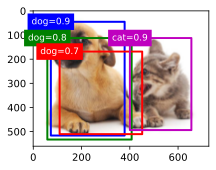

In [19]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

Usamos a função `multibox_detection` para executar NMS e definir o limite para 0,5. Isso adiciona uma dimensão de exemplo à entrada do tensor. Podemos ver que a forma do resultado retornado é (tamanho do lote, número de caixas de âncora, 6). Os 6 elementos de cada linha representam as informações de saída para a mesma caixa delimitadora de previsão. O primeiro elemento é o índice de categoria previsto, que começa em 0 (0 é cachorro, 1 é gato). O valor -1 indica fundo ou remoção no NMS. O segundo elemento é o nível de confiança da caixa delimitadora de previsão. Os quatro elementos restantes são as coordenadas do eixo $x, y$ do canto superior esquerdo e as coordenadas do eixo $x, y$ do canto inferior direito da caixa delimitadora de previsão (o intervalo de valores está entre 0 e 1).


In [20]:
output = multibox_detection(cls_probs.unsqueeze(dim=0),
                            offset_preds.unsqueeze(dim=0),
                            anchors.unsqueeze(dim=0),
                            nms_threshold=0.5)
output

tensor([[[ 0.00,  0.90,  0.10,  0.08,  0.52,  0.92],
         [ 1.00,  0.90,  0.55,  0.20,  0.90,  0.88],
         [-1.00,  0.80,  0.08,  0.20,  0.56,  0.95],
         [-1.00,  0.70,  0.15,  0.30,  0.62,  0.91]]])

Removemos as caixas delimitadoras de predição da categoria -1 e visualizamos os resultados retidos pelo NMS.


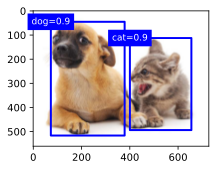

In [21]:
fig = d2l.plt.imshow(img)
for i in output[0].detach().numpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [torch.tensor(i[2:]) * bbox_scale], label)

Na prática, podemos remover caixas delimitadoras de predição com níveis de confiança mais baixos antes de executar NMS, reduzindo assim a quantidade de computação para NMS. Também podemos filtrar a saída de NMS, por exemplo, retendo apenas os resultados com níveis de confiança mais altos como saída final.


## Resumo

* Geramos várias caixas de âncora com diferentes tamanhos e proporções de aspecto, centralizadas em cada pixel.
* IoU, também chamado de índice de Jaccard, mede a similaridade de duas caixas delimitadoras. É a proporção entre a área de intersecção e a área de união de duas caixas delimitadoras.
* No conjunto de treinamento, marcamos dois tipos de rótulos para cada caixa de âncora: um é a categoria do alvo contido na caixa de âncora e o outro é o deslocamento da caixa delimitadora de verdade em relação à caixa de âncora.
* Ao prever, podemos usar supressão não máxima (NMS) para remover caixas delimitadoras de previsão semelhantes, simplificando assim os resultados.

## Exercícios

1. Altere os valores de `sizes` e` ratios` na função `multibox_prior` e observe as alterações nas caixas de âncora geradas.
1. Construa duas caixas delimitadoras com uma IoU de 0,5 e observe sua coincidência.
1. Verifique a saída de offset `labels[0]` marcando os offsets da caixa de âncora conforme definido nesta seção (a constante é o valor padrão).
1. Modifique a variável `anchors` nas seções" Rotulando Caixas de Âncora de Conjunto de Treinamento "e" Caixas Limitadoras de Saída para Previsão ". Como os resultados mudam?


[Discussões](https://discuss.d2l.ai/t/1603)


<!--stackedit_data:
eyJoaXN0b3J5IjpbLTIwMTg3MDU3MDksODkzNTI1MzAyLC0xOD
UyMDQwNDkzLC0xNDU5OTQ4MDMsLTUxMzMxNTM2MSwtMTY4ODA5
ODE2OCwxNjk3NTA1MjI1LC01NDExMTc5MzUsLTkxNTAxMjc5Mi
wtMTM1NjI1MzgwMSwxNTQ2MjQwNDg2LC0xNDkzNDA1OTQyLDE4
OTE1NzI5OTcsLTQ5MDQ0MDcwMywxNzQ2MjMzNDc3XX0=
-->
